In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

11_07_24


In [2]:
import sys
# sys.path.append('/path/to/the/folder/of/your/module/file')
sys.path

['/Users/maryumsayeed/Desktop/Code/Research/espresso_lirich/scripts',
 '/opt/miniconda3/lib/python39.zip',
 '/opt/miniconda3/lib/python3.9',
 '/opt/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/opt/miniconda3/lib/python3.9/site-packages',
 '/opt/miniconda3/lib/python3.9/site-packages/certifi-2022.9.24-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/ipython_genutils-0.2.0-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/fits2hdf-1.1.1-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/maryumsayeed/.ipython']

In [3]:
#pip install thejoker

In [4]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az

In [5]:
#p112 = glob.glob('../data/spectra/*.fits')


In [6]:
files = glob.glob('../data/P113_data/*.fits')
# files = glob.glob('../data/spectra/*.fits')

In [96]:

hdul = fits.open(files[0])
header  = hdul[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-08-05T08:25:50' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
OBJECT  = 'TYC 8728-2561-1'    / Original target.                               
RA      =           263.138659 / [deg] Spectroscopic target position (J2000)    
DEC     =            -53.58522 / [deg] Spectroscopic target position (J2000)    
EXPTIME =                 300. / [s] Total integration time per pixel           
MJD-OBS =       60497.138813

In [8]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [9]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [10]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [11]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [12]:
# from: https://www.eso.org/rm/api/v1/public/releaseDescriptions/176
# Barycentric correction. The wavelengths in the science spectrum are correct to the barycentre of
# the solar system. 

In [13]:
# header.cards

In [14]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        grade   = header['OB_GRADE'].replace(" ", "")
        if grade =='C':
            print('RG',obj,header['OB_GRADE'])
            continue
            
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
            obj_dir[obj]['grade'].append(grade)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name], 'grade': [grade]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [15]:
obj_dir

{1: {'rv': [25.0457252755331,
   25.0568689052661,
   24.457863372332,
   25.0409222476875,
   25.1447923970687],
  'time': [2460533.54547529,
   2460499.69626092,
   2460455.8596566,
   2460516.5623766,
   2460473.83231935],
  'err': [0.0643989386695004,
   0.0637748847898338,
   0.0695164067729217,
   0.0703917118789862,
   0.067555111047552],
  'name': ['UCAC4 139-176959',
   'UCAC4 139-176959',
   'UCAC4 139-176959',
   'UCAC4 139-176959',
   'UCAC4 139-176959'],
  'grade': ['A', 'A', 'B', 'A', 'A']},
 2: {'rv': [-54.5343033092308,
   -54.4574497826583,
   -54.5147658471557,
   -54.4251674938846,
   -54.4738210120523],
  'time': [2460504.53073381,
   2460476.67040251,
   2460520.76878159,
   2460536.54016409,
   2460458.83120667],
  'err': [0.0110808225698425,
   0.012747893649292,
   0.0109379406280295,
   0.0100231931384666,
   0.0093821752106121],
  'name': ['UCAC4 143-204046',
   'UCAC4 143-204046',
   'UCAC4 143-204046',
   'UCAC4 143-204046',
   'UCAC4 143-204046'],
  'grade'

In [16]:
new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

for k, v in obj_dir.items():
    result_table = Simbad.query_objectids(v['name'][0])
    result_table = np.array(result_table).astype('str')
    
    for i in result_table:
        if 'GALAH' in i: 
            galah_name = i.split(' ')[-1]

    new_df['RG_id'].append(k)
    new_df['galah_id'].append(int(galah_name))
    new_df['obj_name'].append(v['name'][0])
    
new_df = pd.DataFrame(new_df)
print(type(new_df))
print(type(galah))

new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05

cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'vbroad', 'fe_h','ruwe_dr2']
new_df.columns


print(new_df[cols].to_latex(index=False))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
\begin{tabular}{rrlrrrr}
\toprule
RG_id & galah_id & obj_name & Li_val & vbroad & fe_h & ruwe_dr2 \\
\midrule
1 & 140806001701013 & UCAC4 139-176959 & 3.315363 & 18.760988 & -0.433131 & 1.006641 \\
2 & 170802003201248 & UCAC4 143-204046 & 1.562654 & 7.018259 & -0.081303 & 1.148626 \\
3 & 150429004102159 & 2MASS J16094423-2557437 & 2.551367 & 15.344798 & -0.794666 & 1.002648 \\
4 & 170602003701360 & 2MASS J14255395-3724226 & 2.951271 & 10.948685 & -0.785534 & 1.170869 \\
5 & 170416004301008 & UCAC4 308-077592 & 4.800583 & 6.923448 & -1.673664 & 0.855937 \\
6 & 170906002101305 & UCAC4 160-209706 & 2.671148 & 27.101101 & -0.449312 & 1.164001 \\
7 & 160521004801082 & UCAC4 212-183136 & 4.234569 & 15.175632 & -1.400953 & 0.985253 \\
8 & 170517004501165 & UCAC3 92-415399 & 3.839334 & 6.380539 & -0.514983 & 0.995525 \\
9 & 140707003101315 & ATO J337.2658-06.4234 & 1.537408 & 12.102224 & -0.796162 & 0.959484 \\
10 & 16

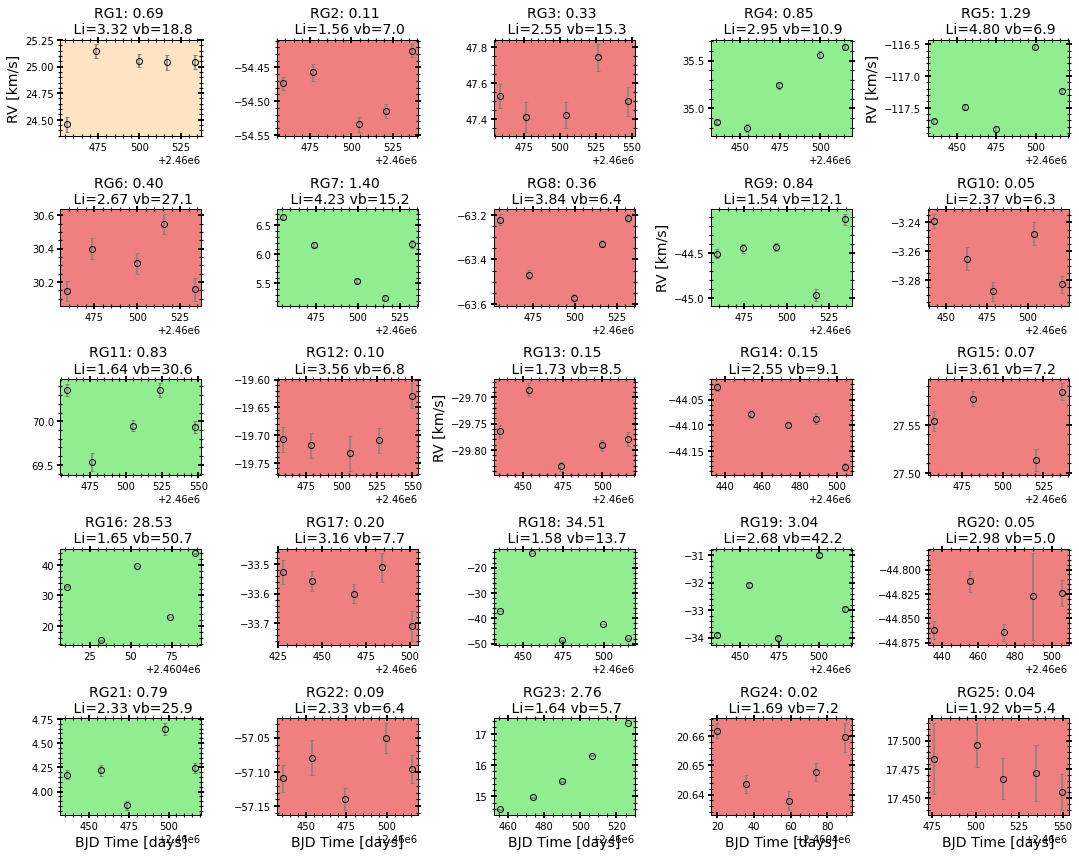

In [17]:
#PLOT_PARAMS(LS=12)

stats = {'RG_id':[], 'A': []}
plt.figure(figsize=(15,12))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(5,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        yerr    = np.array(obj_dir[obj]['err'])
        
        if obj != 5:
            mask    = (rv_vals >= -100)
            time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            obj_dir[obj]['time'] = time
            obj_dir[obj]['rv'] = rv_vals
            obj_dir[obj]['err'] = yerr
            
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')

        diff = abs(max(rv_vals)-min(rv_vals))
        if diff < 0.5:
            ax.set_facecolor('lightcoral')
        elif 0.5 <= diff < 0.7:
            ax.set_facecolor('bisque')
        elif 0.7 <= diff <= 50:
            ax.set_facecolor('lightgreen')

        li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].to_numpy()[0]
        title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
        plt.title(title)
        stats['RG_id'].append(obj)
        stats['A'].append(diff)

#         elif title in ['RG4','RG24','RG13','RG7']:
#             ax.set_facecolor('lightblue')
        if i >= 20: plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')


plt.tight_layout()


stats = pd.DataFrame(stats)

# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

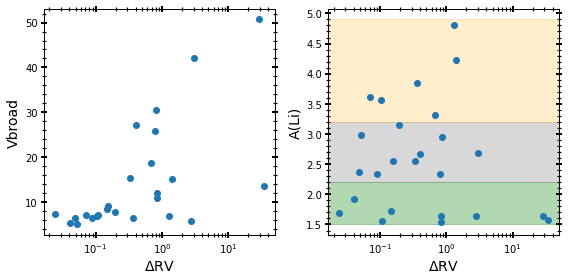

In [18]:
params = pd.merge(new_df, stats, on='RG_id')
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(params.A, params.vbroad)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('Vbroad')

plt.subplot(122)
plt.scatter(params.A, params.Li_val)
plt.axhspan(1.5, 2.2, color='green',alpha=0.3,zorder=0)
plt.axhspan(2.2, 3.2, color='grey',alpha=0.3,zorder=0)
plt.axhspan(3.2, 4.9, color='orange',alpha=0.2,zorder=0)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('A(Li)')
plt.tight_layout()

In [143]:
def test_tj(obj,prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])*10
    print('mean error now: %.3f km/s'%np.mean(data['rv_err']))
#     data['rv_err'] = [0.5]*len(data['rv'])
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 2, 5e3), u.day)
        K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        prior = tj.JokerPrior.default(
                # to use Joker's default log-normal, give P-min, P-max
                P_min = 0.25 * u.day, 
                P_max = 1e3 * u.day,
                #sigma_K0=20 * u.km / u.s,
                #sigma_v=100 * u.km / u.s,
            sigma_v=[100 * u.km / u.s, 0.5 * u.km / u.s / u.day, 1e-2 * u.km / u.s / u.day**2],
            poly_trend=3,
                pars={#'P': P_prior,
                      'K': K_prior}
#                       'e': e_prior}
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=4)

        az.summary(trace, var_names=prior.par_names)
        
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2']
        truth = ['P','e','K','v0', 'v1', 'v2']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples



mean error originally: 0.095 km/s
mean error now: 0.951 km/s
<JokerSamples [e, omega, M0, s, P] (1000000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0, v1, v2] (256 samples)>


<ipython-input-143-f9e5aa2cf205>:56: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=4)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]
INFO:pymc.sampling.mcmc:NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 237 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 237 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample

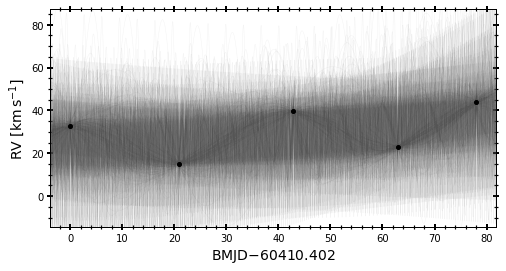

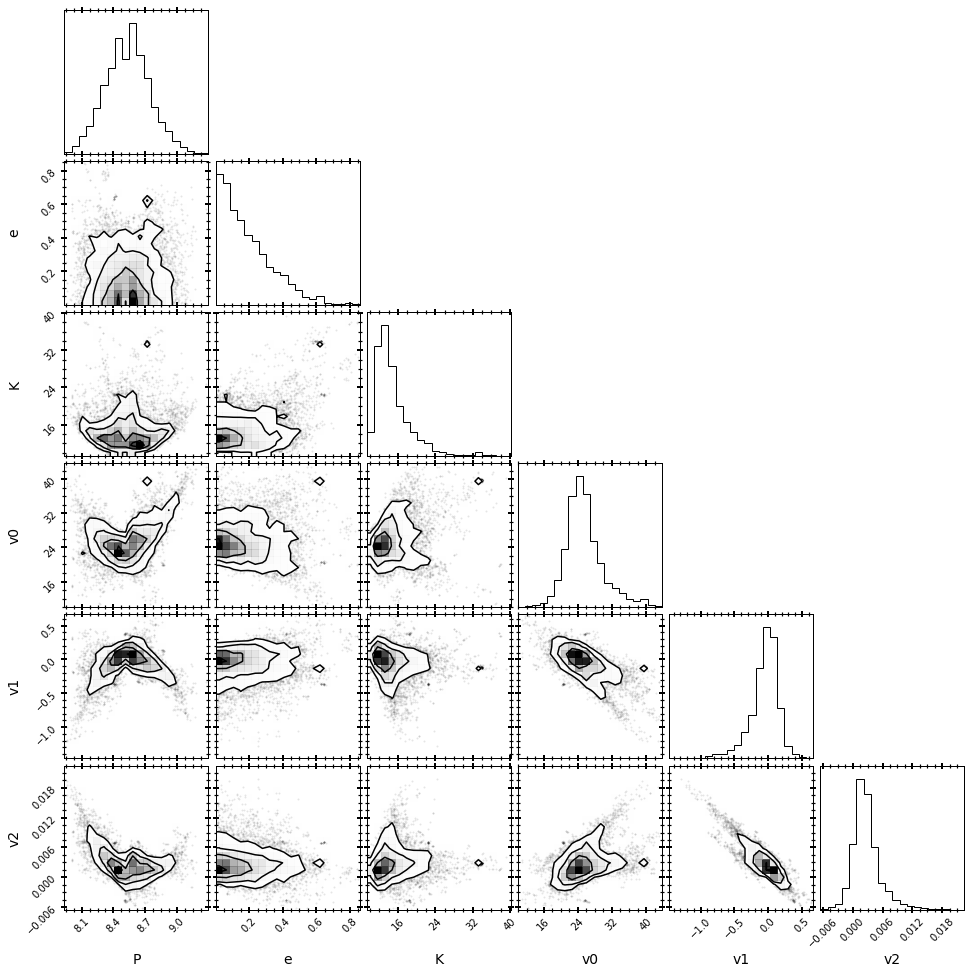

In [144]:
ps_5, js_5, ms_5 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

mean error originally: 0.095 km/s
mean error now: 0.951 km/s
<JokerSamples [omega, M0, s, P, e] (200000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0, v1, v2] (256 samples)>


<ipython-input-138-67c9f6ed1f77>:56: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]
INFO:pymc.sampling.mcmc:NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 192 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 192 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain

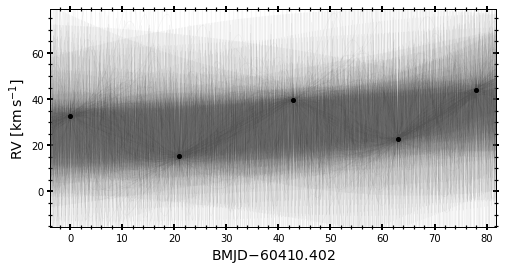

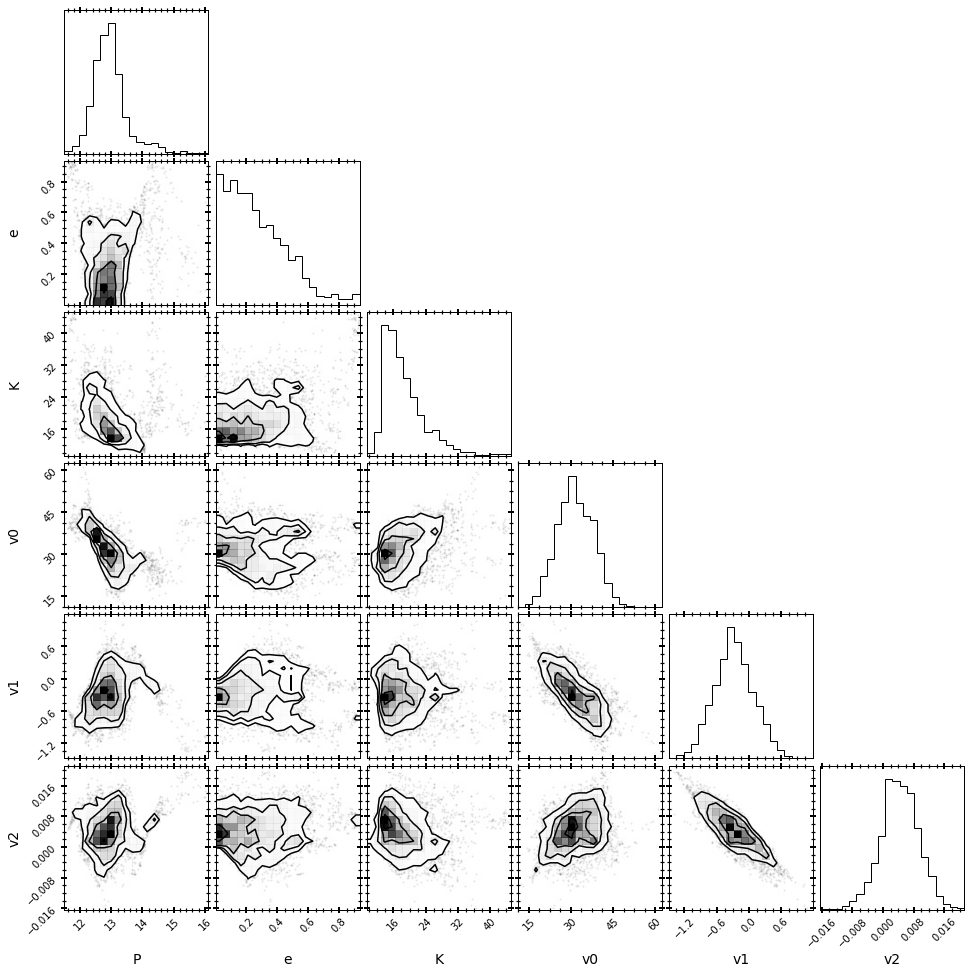

In [139]:
# default prior in e
ps_4, js_4, ms_4 = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)

mean error originally: 0.095 km/s
mean error now: 0.951 km/s
<JokerSamples [omega, M0, s, P, e] (200000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0, v1, v2] (256 samples)>


<ipython-input-122-afb5c5db0ab9>:56: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]
INFO:pymc.sampling.mcmc:NUTS: [K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, v0, v1, v2]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.
There were 497 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 497 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per cha

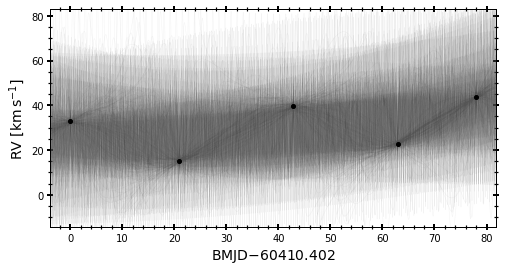

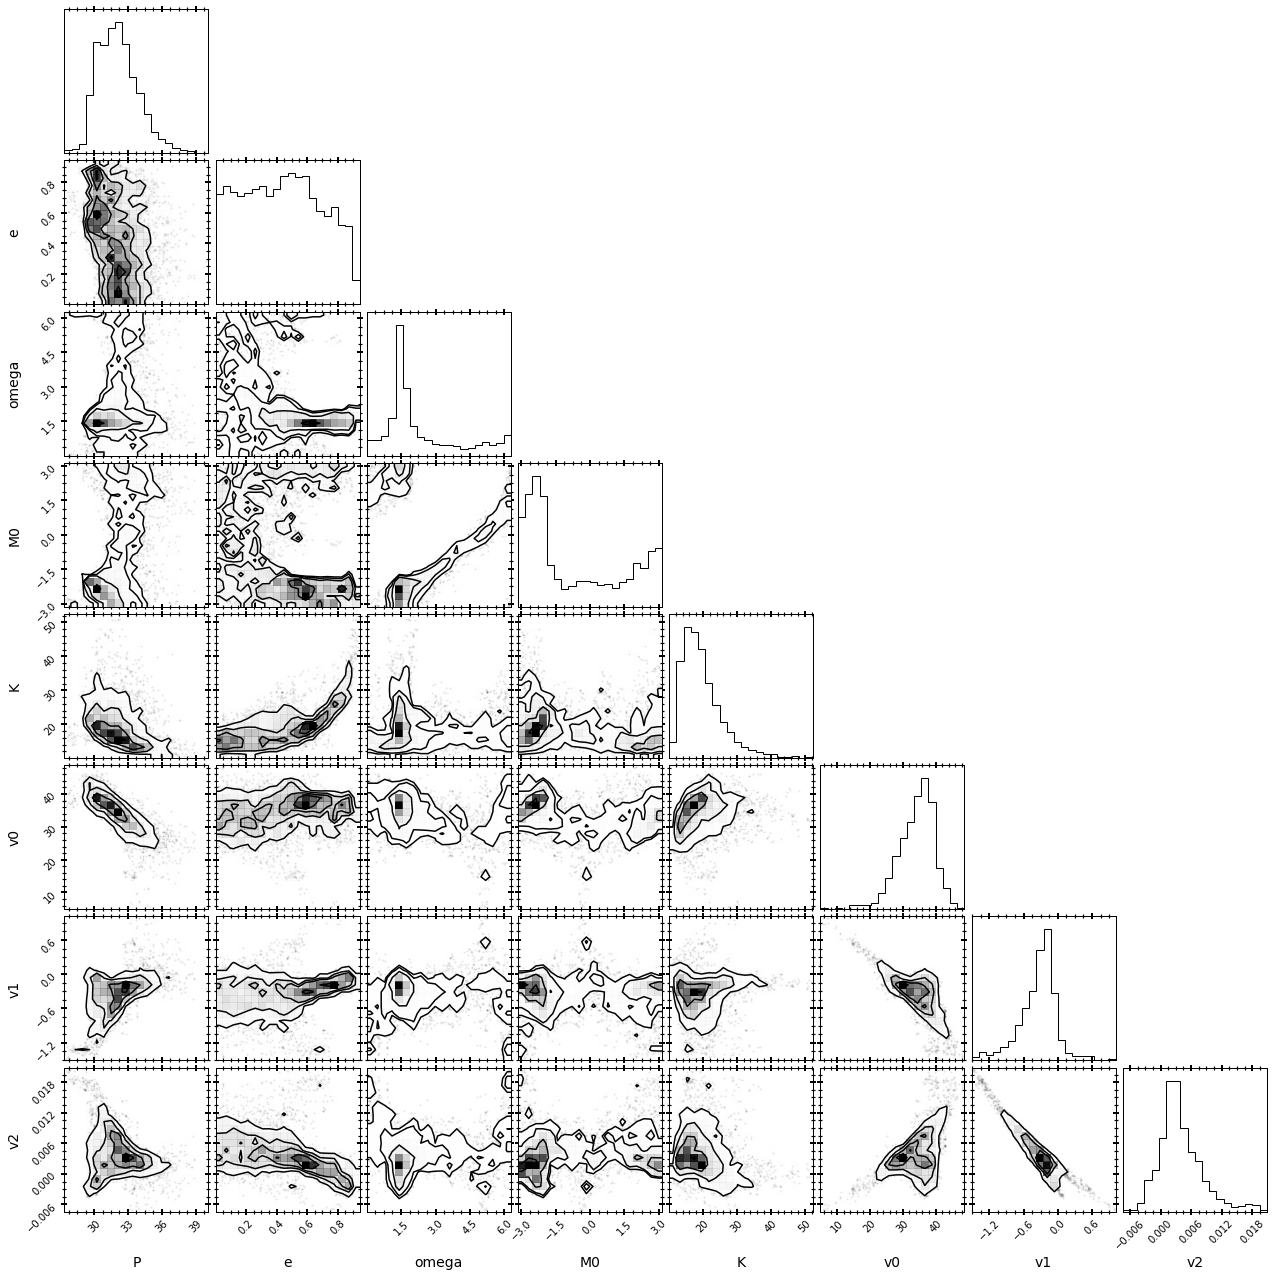

In [125]:
# uniform prior in e
ps_3, js_3 = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)

mean error originally: 0.095 km/s
mean error now: 0.951 km/s
<JokerSamples [omega, M0, s, P, e] (1000000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0, v1, v2] (236 samples)>


<ipython-input-104-e48d0fa5d133>:55: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=4)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0, v1, v2]
INFO:pymc.sampling.mcmc:NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0, v1, v2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 394 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 394 seconds.
There were 1229 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 1229 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sa

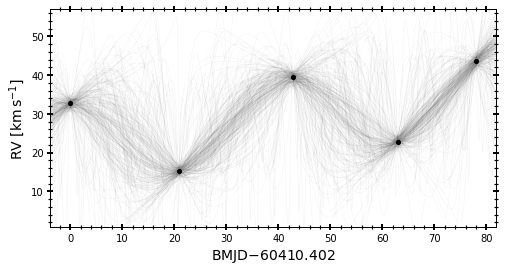

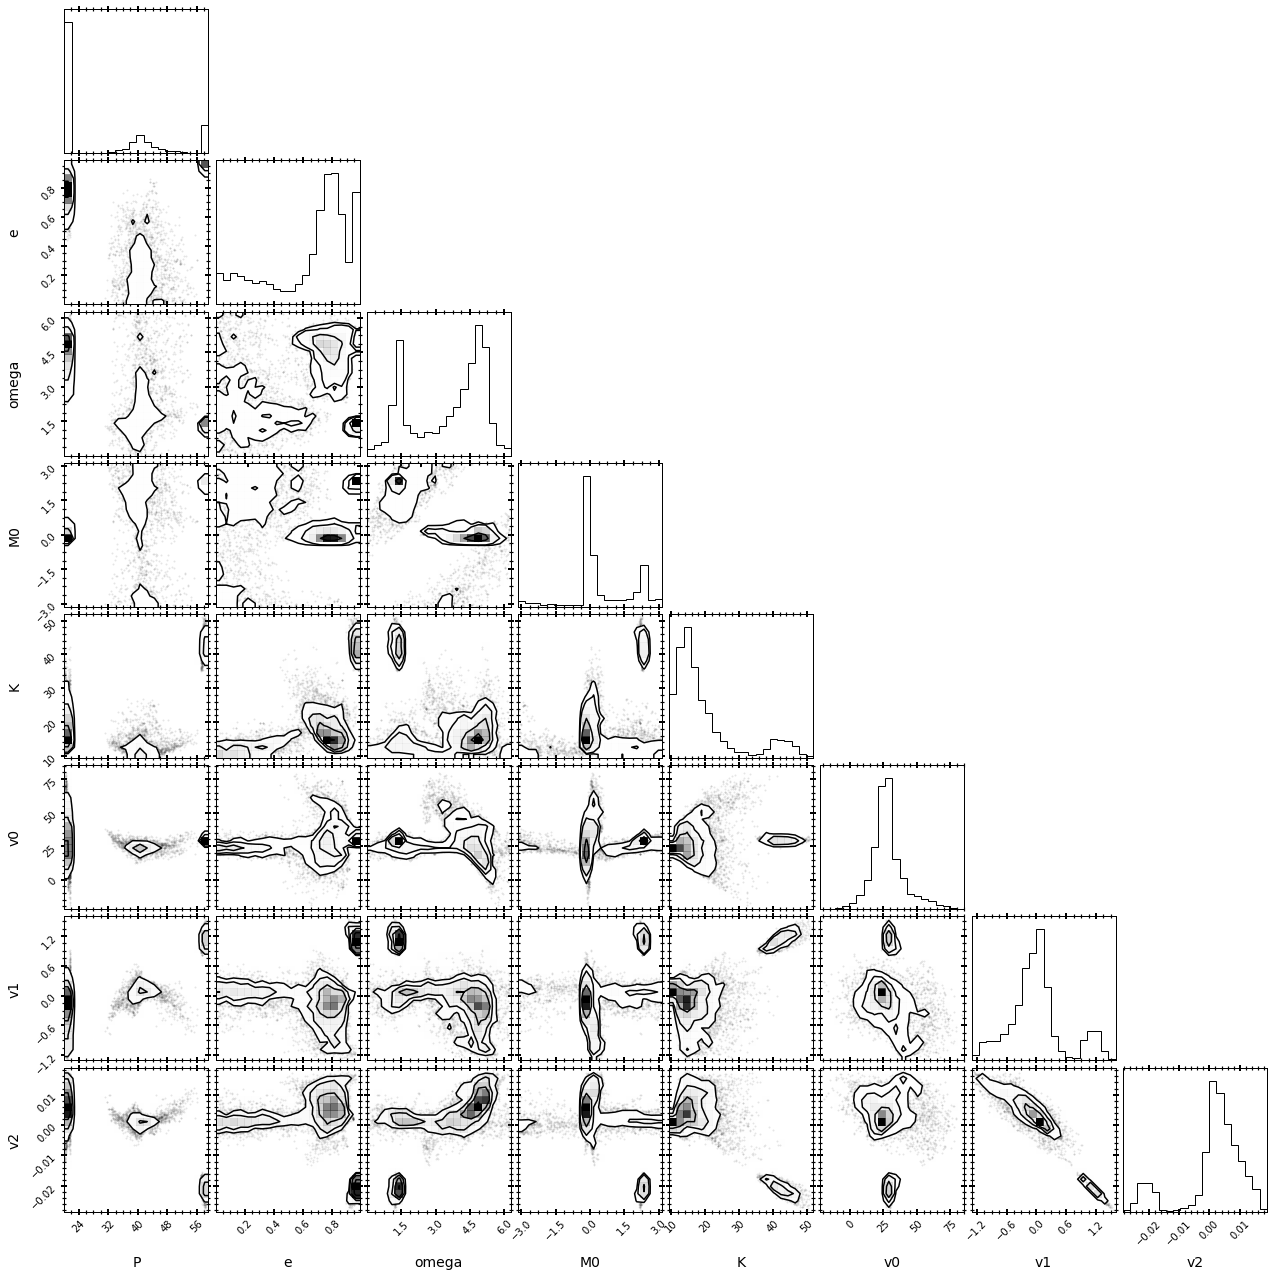

In [105]:
ps_2, js_2 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

mean error originally: 0.095 km/s
mean error now: 0.951 km/s
<JokerSamples [e, omega, M0, s, P] (200000 samples)>


<ipython-input-32-9671887507bb>:52: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain

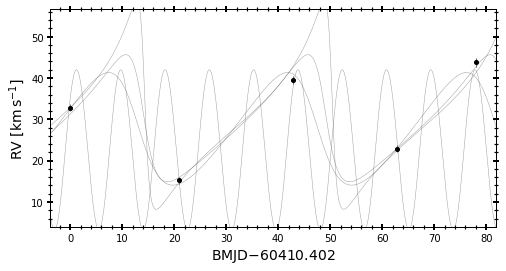

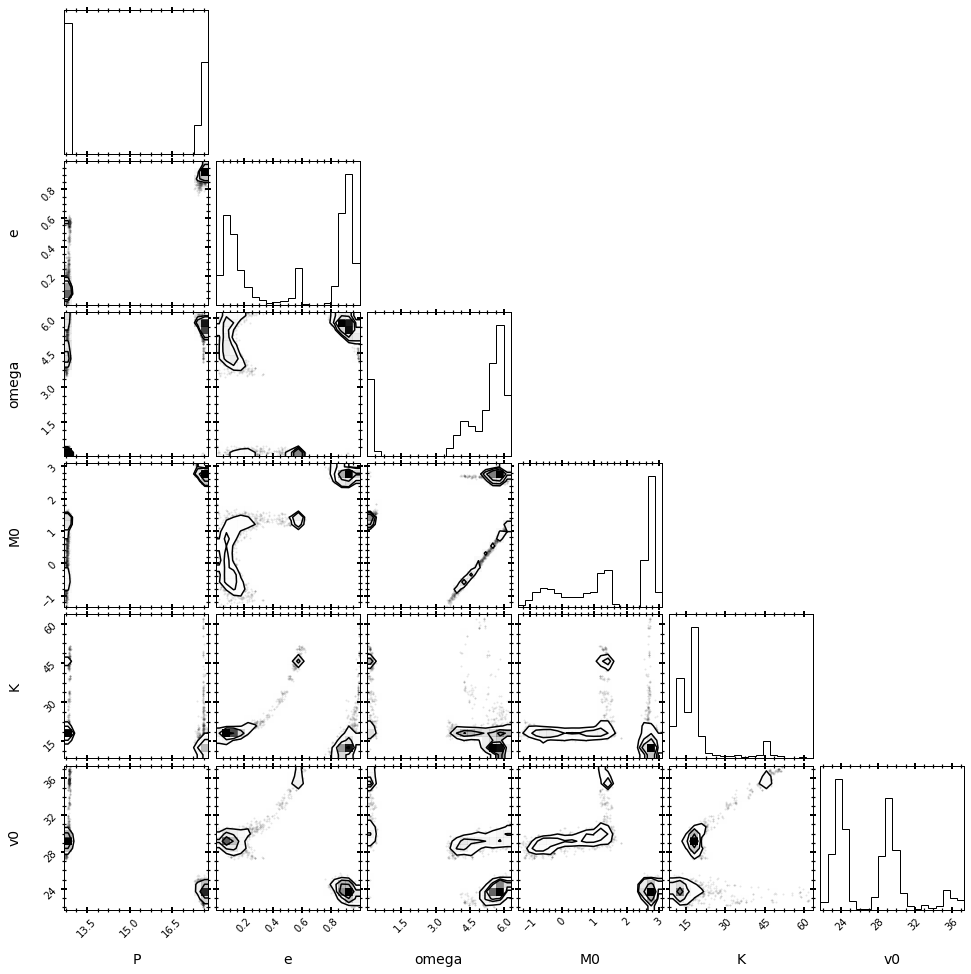

In [34]:

rg16_ps_err_x_10_L, rg16_js_err_x_10_L = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
ss

In [ ]:
ps_err_x_1, js_err_x_1 = test_tj(18, prior_size=250_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_err_x_10, js_err_x_10 = test_tj(18, prior_size=250_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_err_x_10_L, js_err_x_10_L = test_tj(18, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:

_=plt.hist(js[1],bins='auto')
plt.xlabel('Joker Samples')
plt.yscale('log')



In [ ]:
ss

In [ ]:
binaries = [23, 13, 7, 6, 5, 4, 1]
for star_id in binaries[1:]:#list(obj_dir.keys()):
    print(star_id)
    test_tj(star_id, prior_size=250_000, save=True, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ts1, ts2 = test_tj(13,prior_size=50_000,save=False,MCMC=False)

In [ ]:
_=plt.hist(ts1[1],bins='auto')
_=plt.hist(ts2[1],bins='auto')
plt.yscale('log')


In [ ]:
test_tj(13,prior_size=50_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=2_500_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
plt.hist(prior_samples_dict[13]['P'].to_value())


In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=True)

In [ ]:
prior_samples_dict = dict.fromkeys(obj_dir)
joker_samples_dict = dict.fromkeys(obj_dir)
for ob in list(obj_dir.keys())[1:]:
    ps, js = test_tj(ob,prior_size=250_000,save=False,MCMC=True)
    prior_samples_dict[ob] = ps
    joker_samples_dict[ob] = js
    

In [ ]:
joker_samples_dict[6]

In [ ]:
plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P']):
    plt.subplot(2,3,i+1)
    plt.hist(prior_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()

plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P','K','v0']):
    plt.subplot(3,3,i+1)
    plt.hist(joker_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()